In [ ]:
# NOTE: Make sure the external packages are installed in Colab
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install matplotlib tqdm

In [ ]:
import tqdm
import torch
import numpy as np
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, CenterCrop
import matplotlib.pyplot as plt
from pytorch_metric_learning import miners, losses, distances
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
# Google Colab Patch
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    # ----------------------------------------
    dir = "/content/drive/MyDrive/Colab Notebooks"    
    # ----------------------------------------
    sys.path.append(dir)

from vit_model import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Hyperparameters
# NOTE: Feel free to add & modify hyperparameters if needed
num_epochs = 50
batch_size = 512
weight_decay = 1e-4
lr = 0.001       

# ViT specifics
image_size = 28
in_channels = 1
patch_size = 4
hidden_size = 64
layers = 6
heads = 8
embed_size = 64

# Contrastive Learning specifics
margin = 0.2

In [ ]:
# Load FashionMNIST dataset
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(classes)

tfm_train = Compose([

    RandomHorizontalFlip(),
    RandomCrop(size=(image_size, image_size)),
    ToTensor(),
    Normalize((0.5, ), (0.5, )),
    ])

tfm_test = Compose([
    ToTensor(),
    Normalize((0.5, ), (0.5, )),
    ])

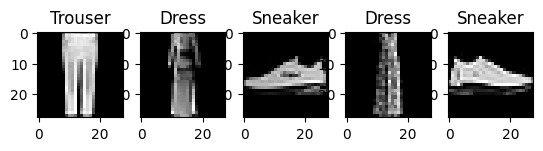

In [ ]:
def inverse_transform(
    img_tensor: torch.Tensor,
    ) -> np.ndarray:
    """Given a preprocessed image tensor, revert the normalization process and
    convert the tensor back to a numpy image.
    """
    inv_normalize = Normalize(mean=(-0.5/0.5, ), std=(1/0.5, ))
    img_tensor = inv_normalize(img_tensor).permute(1, 2, 0)
    img = np.uint8(255 * img_tensor.numpy())
    return img

# Get some random training images
n_imgs = 5
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tfm_train)
indices = np.random.randint(0, len(dataset), size=(n_imgs, ))

# Visualize with matplotlib
for i, idx in enumerate(indices):
    img_tensor, label = dataset[idx]
    img = inverse_transform(img_tensor)
    plt.subplot(1, n_imgs, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(classes[label])

plt.show()

In [ ]:
# Train a Classifier
# -----

def train_classification_model():
    # Base ViT
    vit_model = ViT(
        image_size=image_size,
        patch_size=patch_size,
        num_channels=in_channels,
        hidden_size=hidden_size,
        layers=layers,
        heads=heads)

    # Classifier
    model_classifier = ClassificationHead(hidden_size=vit_model.hidden_size, num_classes=num_classes)
    if torch.cuda.is_available():
        vit_model = vit_model.cuda()
        model_classifier = model_classifier.cuda()

    # Use cross entropy
    criterion = nn.CrossEntropyLoss()

    # Specify optimizer
    parameters = list(vit_model.parameters()) + list(model_classifier.parameters())
    optimizer = torch.optim.AdamW(
        parameters,
        lr=lr, weight_decay=weight_decay)

    # Evaluate at the end of each epoch
    best_acc = 0.0

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(train_loader):
            vit_model.train()
            model_classifier.train()

            if torch.cuda.is_available():
                x = x.cuda()
                labels = labels.cuda()

            # Forward pass
            feats = vit_model(x)
            outputs = model_classifier(feats)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: Show train loss at the end of epoch
            if (i+1) % len(train_loader) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        # Evaluate at the end
        test_acc = test_classification_model(vit_model, model_classifier)
        if test_acc > best_acc:
            best_acc = test_acc
            state_dict = {
                "classifier": model_classifier.state_dict(),
                "vit": vit_model.state_dict(),
                "acc": best_acc,
            }
            torch.save(state_dict, "vit_classifier.pt")
            print("Best test acc:", best_acc)
        print()

def test_classification_model(
    vit_model: nn.Module,
    model_classifier: nn.Module,
    ):
    # Test the model
    vit_model.eval()
    model_classifier.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            feats = vit_model(images)
            outputs = model_classifier(feats)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # print('Test Accuracy: {} %'.format(100 * correct / total))
    return correct / total

In [ ]:
# NOTE: Uncomment this to test your ViT implementation

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tfm_train)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tfm_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# train_classification_model()

# del train_dataset
# del test_dataset

In [ ]:
# Sample a subset of training dataset
# NOTE: sample an even number of samples per class
# To migrate the problem of [class imbalancing]
# (https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data).
def sample_balanced_subset(
    train_dataset,
    n_samples_per_class: int = 50,
    n_classes: int = 10
    ):
    maps = {i: [] for i in range(n_classes)}
    for idx, (_, cls_idx) in enumerate(train_dataset):
        if len(maps[cls_idx]) < n_samples_per_class:
            maps[cls_idx].append(idx)

    indices = []
    for _, ind in maps.items():
        indices += ind

    train_subset = torch.utils.data.Subset(train_dataset, indices)
    print("Num. samples in subset:", len(train_subset))
    return train_subset

# Subsample a small subset from the full train dataset
full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tfm_train)
train_dataset = sample_balanced_subset(full_train_dataset, n_samples_per_class=500)      # DO NOT MODIFY THIS CODE

# Full test set will still be used for testing
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tfm_test)

Num. samples in subset: 5000


In [ ]:
# Train an embedding model
# -----

def train_embedding_model(
    train_dataset,
    test_dataset,
    ):
    #########################
    # Finish Your Code HERE
    # #########################

    # Dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Evaluate model per epoch, and keep track of the model performance at that time
    best_prec = 0.0

    # Triplet Loss with Semi-hard triples & l2 distance
    # -------------------
    # Source: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR
    #         https://kevinmusgrave.github.io/pytorch-metric-learning/distances/


    distance = distances.LpDistance(power=2)
    criterion = losses.TripletMarginLoss(margin=0.2, distance=distance)
    miner = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")        # Make sure to use "semihard" triplets
    # -------------------

    # Precision to test embedding quality
    accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

    # Models to train
    # -------------------
    vit_model = ViT(image_size, patch_size, in_channels, hidden_size, layers, heads)
    model_embedding = LinearEmbeddingHead(hidden_size, embed_size)

    if torch.cuda.is_available():
        vit_model = vit_model.cuda()
        model_embedding = model_embedding.cuda()

    # -------------------

    # Specify optimizer
    # -------------------
    parameters = list(vit_model.parameters()) + list(model_embedding.parameters())      

    optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=weight_decay) 

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0) 

    # -------------------

    # Train loop
    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(train_loader):
            vit_model.train()
            model_embedding.train()

            if torch.cuda.is_available():
                x = x.cuda()
                labels = labels.cuda()

            # Forward pass
            # -------------------
            embeddings = model_embedding(vit_model(x))
            loss = criterion(embeddings, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # -------------------

            # NOTE: Show train loss at the end of epoch
            # Feel free to modify this to log more steps
            if (i+1) % len(train_loader) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        # Evaluate at the end
        best_prec = evaluate_at_end_epoch(vit_model, model_embedding, accuracy_calculator, best_prec, train_dataset, test_dataset)

    # #########################

def get_embeddings(
    x: torch.Tensor,
    vit_model: nn.Module,
    model_embedding: nn.Module,
    ) -> torch.Tensor:
    """Calculate embeddings for a batch of images.
    """
    if torch.cuda.is_available():
        x = x.cuda()

    with torch.no_grad():
        vit_model.eval()
        model_embedding.eval()
        x_embeds = model_embedding(vit_model(x))

    x_embeds = x_embeds.cpu()   # Cast to CPU
    x_embeds = torch.nn.functional.normalize(x_embeds, p=2, dim=1)      # Extra Step: Normalize the embeddings
    return x_embeds

def get_embeddings_over_dataset(
    dataset,
    vit_model: nn.Module,
    model_embedding: nn.Module,
    ):
    """Loop through a full dataset and return all embeddings.
    """
    # Create a loader on the go
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    X_embeds, Y = [], []
    for i, (x, y) in enumerate(tqdm.tqdm(loader)):
        x_embeds = get_embeddings(x, vit_model, model_embedding)
        X_embeds.append(x_embeds)
        Y.append(y)

    X_embeds = torch.cat(X_embeds, dim=0)
    Y = torch.cat(Y, dim=0)
    return X_embeds, Y

def test_embedding_model(
    vit_model: nn.Module,
    model_embedding: nn.Module,
    accuracy_calculator,
    train_dataset,
    test_dataset,
    ):
    # Test the model
    model_embedding.eval()

    X_embeds, Y = get_embeddings_over_dataset(train_dataset, vit_model, model_embedding)
    X_embeds_test, Y_test = get_embeddings_over_dataset(test_dataset, vit_model, model_embedding)
    accuracies = accuracy_calculator.get_accuracy(
        X_embeds_test, Y_test, X_embeds, Y, False
    )
    return accuracies["precision_at_1"]

def evaluate_at_end_epoch(
    vit_model: nn.Module,
    model_embedding: nn.Module,
    accuracy_calculator,
    best_prec: float,
    train_dataset,
    test_dataset,
    ):
    # Evaluate at the end
    prec = test_embedding_model(vit_model, model_embedding, accuracy_calculator, train_dataset, test_dataset)
    if prec > best_prec:
        best_prec = prec
        state_dict = {
            "embedding_head": model_embedding.state_dict(),
            "vit": vit_model.state_dict(),
            "precision@1": prec,
        }
        torch.save(state_dict, "vit_embeds.pt")
        print("Best Precision@1:", best_prec)
    print()
    return best_prec


In [ ]:
torch.cuda.empty_cache()    # Clean-up memory 1st
train_embedding_model(train_dataset, test_dataset)

Epoch [1/50], Step [10/10], Loss: 0.1566


100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Best Precision@1: 0.6967



/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Epoch [2/50], Step [10/10], Loss: 0.1937


100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Best Precision@1: 0.7115

Epoch [3/50], Step [10/10], Loss: 0.1932


100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Best Precision@1: 0.7244

Epoch [4/50], Step [10/10], Loss: 0.1860


100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Best Precision@1: 0.7341000000000001

Epoch [5/50], Step [10/10], Loss: 0.2052


100%|██████████| 20/20 [00:02<00:00,  8.78it/s]



Epoch [6/50], Step [10/10], Loss: 0.2097


100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Best Precision@1: 0.7354

Epoch [7/50], Step [10/10], Loss: 0.1886


100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Best Precision@1: 0.7381000000000001

Epoch [8/50], Step [10/10], Loss: 0.2058


100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


Best Precision@1: 0.7542

Epoch [9/50], Step [10/10], Loss: 0.1928


100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Best Precision@1: 0.7627

Epoch [10/50], Step [10/10], Loss: 0.2029


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Best Precision@1: 0.768

Epoch [11/50], Step [10/10], Loss: 0.1558


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Best Precision@1: 0.7727

Epoch [12/50], Step [10/10], Loss: 0.2266


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Best Precision@1: 0.7773

Epoch [13/50], Step [10/10], Loss: 0.1791


100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Best Precision@1: 0.7851

Epoch [14/50], Step [10/10], Loss: 0.2422


100%|██████████| 20/20 [00:02<00:00,  7.51it/s]



Epoch [15/50], Step [10/10], Loss: 0.2078


100%|██████████| 20/20 [00:02<00:00,  9.00it/s]



Epoch [16/50], Step [10/10], Loss: 0.1998


100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Best Precision@1: 0.7891

Epoch [17/50], Step [10/10], Loss: 0.1965


100%|██████████| 20/20 [00:02<00:00,  8.94it/s]



Epoch [18/50], Step [10/10], Loss: 0.1790


100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Best Precision@1: 0.7899

Epoch [19/50], Step [10/10], Loss: 0.1926


100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Best Precision@1: 0.7932

Epoch [20/50], Step [10/10], Loss: 0.1920


100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Best Precision@1: 0.7956000000000001

Epoch [21/50], Step [10/10], Loss: 0.1894


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Best Precision@1: 0.7979

Epoch [22/50], Step [10/10], Loss: 0.2233


100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Best Precision@1: 0.8038000000000001

Epoch [23/50], Step [10/10], Loss: 0.2276


100%|██████████| 20/20 [00:02<00:00,  7.41it/s]



Epoch [24/50], Step [10/10], Loss: 0.1877


100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Best Precision@1: 0.8052

Epoch [25/50], Step [10/10], Loss: 0.2308


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]



Epoch [26/50], Step [10/10], Loss: 0.2215


100%|██████████| 20/20 [00:02<00:00,  9.20it/s]



Epoch [27/50], Step [10/10], Loss: 0.2208


100%|██████████| 20/20 [00:03<00:00,  5.71it/s]



Epoch [28/50], Step [10/10], Loss: 0.2057


100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Best Precision@1: 0.8069000000000001

Epoch [29/50], Step [10/10], Loss: 0.2003


100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


Best Precision@1: 0.8095

Epoch [30/50], Step [10/10], Loss: 0.2068


100%|██████████| 20/20 [00:02<00:00,  8.98it/s]



Epoch [31/50], Step [10/10], Loss: 0.1839


100%|██████████| 20/20 [00:02<00:00,  7.39it/s]


Best Precision@1: 0.8134

Epoch [32/50], Step [10/10], Loss: 0.2225


100%|██████████| 20/20 [00:02<00:00,  8.88it/s]



Epoch [33/50], Step [10/10], Loss: 0.2050


100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Best Precision@1: 0.8192

Epoch [34/50], Step [10/10], Loss: 0.2062


100%|██████████| 20/20 [00:02<00:00,  9.03it/s]



Epoch [35/50], Step [10/10], Loss: 0.1981


100%|██████████| 20/20 [00:02<00:00,  8.90it/s]



Epoch [36/50], Step [10/10], Loss: 0.1964


100%|██████████| 20/20 [00:02<00:00,  8.72it/s]



Epoch [37/50], Step [10/10], Loss: 0.2107


100%|██████████| 20/20 [00:02<00:00,  8.69it/s]



Epoch [38/50], Step [10/10], Loss: 0.2339


100%|██████████| 20/20 [00:02<00:00,  7.40it/s]


Best Precision@1: 0.8222

Epoch [39/50], Step [10/10], Loss: 0.2278


100%|██████████| 20/20 [00:02<00:00,  8.98it/s]



Epoch [40/50], Step [10/10], Loss: 0.1952


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]



Epoch [41/50], Step [10/10], Loss: 0.1999


100%|██████████| 20/20 [00:02<00:00,  8.83it/s]



Epoch [42/50], Step [10/10], Loss: 0.2018


100%|██████████| 20/20 [00:03<00:00,  5.71it/s]



Epoch [43/50], Step [10/10], Loss: 0.2055


100%|██████████| 20/20 [00:02<00:00,  9.01it/s]



Epoch [44/50], Step [10/10], Loss: 0.2381


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]



Epoch [45/50], Step [10/10], Loss: 0.2092


100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Best Precision@1: 0.8243

Epoch [46/50], Step [10/10], Loss: 0.2140


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Best Precision@1: 0.8270000000000001

Epoch [47/50], Step [10/10], Loss: 0.2325


100%|██████████| 20/20 [00:02<00:00,  8.80it/s]



Epoch [48/50], Step [10/10], Loss: 0.2209


100%|██████████| 20/20 [00:02<00:00,  7.56it/s]



Epoch [49/50], Step [10/10], Loss: 0.2215


100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Best Precision@1: 0.8298000000000001

Epoch [50/50], Step [10/10], Loss: 0.2097


100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


In [ ]:
torch.cuda.empty_cache()    # Clean-up memory 1st

# Load your trained model
# Base ViT
vit_model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_channels=in_channels,
    hidden_size=hidden_size,
    layers=layers,
    heads=heads)

# Embedding head
model_embedding = LinearEmbeddingHead(hidden_size=vit_model.hidden_size, embed_size=embed_size)
if torch.cuda.is_available():
    vit_model = vit_model.cuda()
    model_embedding = model_embedding.cuda()

# Load saved checkpoint
checkpoint = torch.load("vit_embeds.pt")
vit_model.load_state_dict(checkpoint["vit"])
model_embedding.load_state_dict(checkpoint["embedding_head"])

<All keys matched successfully>

In [ ]:
# Sample a bank, which is a small subset of trainset
bank = sample_balanced_subset(train_dataset, n_samples_per_class=25)
X_bank_embeds, Y_bank = get_embeddings_over_dataset(bank, vit_model=vit_model, model_embedding=model_embedding)

Num. samples in subset: 250


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


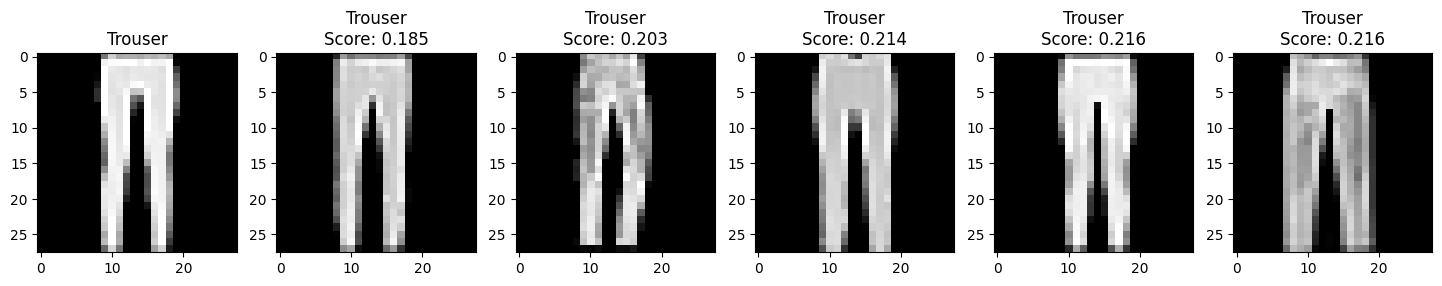

In [ ]:
# Deep KNN
def retrieve_topk_nearest_neighbors_l2(
    query: torch.Tensor,
    ref: torch.Tensor,
    k: int = 5,
    ):
    """Calculate L2 distance between query and ref embeddings.
    Return the top-k scores and the indices of the top-k scores.
    """
    # Sources: https://pytorch.org/docs/stable/generated/torch.norm.html
    #          https://pytorch.org/docs/stable/generated/torch.topk.html

    l2_distances = torch.norm(query - ref, dim=1, p=2)
    top_k_scores, indices = torch.topk(l2_distances, k, largest=False, sorted=True)
    return top_k_scores, indices

# Grab some samples in test set
dataiter = iter(test_loader)
X, Y = next(dataiter)
X_embeds = get_embeddings(X, vit_model=vit_model, model_embedding=model_embedding)

# One random sample
idx = np.random.randint(0, X.shape[0])
img, label, embed = X[idx], Y[idx], X_embeds[idx]

# Get top-k nearest samples
values, indices = retrieve_topk_nearest_neighbors_l2(embed.unsqueeze(0), X_bank_embeds)

# Visualize results
_, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(inverse_transform(img), cmap="gray")
axes[0].set_title(classes[label])
for i, ind in enumerate(indices):
    img_bank, label_bank = bank[ind]
    axes[i + 1].imshow(inverse_transform(img_bank), cmap="gray")
    axes[i + 1].set_title("{}\nScore: {:.3f}".format(classes[label_bank], values[i]))

In [ ]:
# Train a Classifier
# -----

def train_classification_model_head_only(
    vit_model: nn.Module,
    train_dataset,
    test_dataset,
    num_epochs: int = 10,
    ):
    # Classifier
    model_classifier = ClassificationHead(hidden_size=vit_model.hidden_size, num_classes=num_classes)
    best_acc = 0.0

    if torch.cuda.is_available():
        model_classifier = model_classifier.cuda()

    optimizer = torch.optim.AdamW(model_classifier.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(train_loader):
            vit_model.eval()
            model_classifier.train()

            if torch.cuda.is_available():
                x = x.cuda()
                labels = labels.cuda()

            # Forward pass
            feats = vit_model(x)
            outputs = model_classifier(feats)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % len(train_loader) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        test_acc = test_classification_model(vit_model, model_classifier)
        if test_acc > best_acc:
            best_acc = test_acc

        acc = best_acc

    # You should return the weights of your trained model, and the classification score (accuracy)
    return {"acc": acc, "vit": vit_model.state_dict(), "classifier":model_classifier.state_dict()}

def test_classification_model(
    vit_model: nn.Module,
    model_classifier: nn.Module,
    ):
    # Test the model
    vit_model.eval()
    model_classifier.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            feats = vit_model(images)
            outputs = model_classifier(feats)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # print('Test Accuracy: {} %'.format(100 * correct / total))
    return correct / total

In [ ]:
# Train a deep classifier in 5 epochs
train_classification_model_head_only(vit_model, train_dataset, test_dataset)

Epoch [1/10], Step [118/118], Loss: 0.6273
Epoch [2/10], Step [118/118], Loss: 0.5051
Epoch [3/10], Step [118/118], Loss: 0.4939
Epoch [4/10], Step [118/118], Loss: 0.4198
Epoch [5/10], Step [118/118], Loss: 0.4750
Epoch [6/10], Step [118/118], Loss: 0.5966
Epoch [7/10], Step [118/118], Loss: 0.3099
Epoch [8/10], Step [118/118], Loss: 0.3692
Epoch [9/10], Step [118/118], Loss: 0.3169
Epoch [10/10], Step [118/118], Loss: 0.3848


{'acc': 0.8457,
 'vit': OrderedDict([('patch_embed.projection.weight',
               tensor([[[[ 0.0799,  0.1153,  0.3049,  0.0435],
                         [-0.0124,  0.2405,  0.3249, -0.0685],
                         [ 0.1102,  0.0616,  0.0275, -0.1191],
                         [ 0.1066, -0.1578,  0.1920,  0.1234]]],
               
               
                       [[[-0.2036, -0.2127, -0.2515, -0.1361],
                         [ 0.0815, -0.1112,  0.1862,  0.0565],
                         [-0.1126,  0.1013, -0.0860,  0.0704],
                         [ 0.0738, -0.1635, -0.0690,  0.2252]]],
               
               
                       [[[-0.2950,  0.2054,  0.0152, -0.0263],
                         [-0.2377,  0.2526,  0.2530,  0.0593],
                         [ 0.1681,  0.2272,  0.2952,  0.2169],
                         [ 0.0703, -0.1611, -0.1394, -0.2309]]],
               
               
                       ...,
               
               
           